In [3]:
import numpy as np
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from sklearn.pipeline import Pipeline
from glob import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import mdtraj as md

/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Get data

In [4]:
traj_paths = glob('/home/robert/Datasets/DHFR/train/*.dcd')
topfile = '/home/robert/Datasets/DHFR/dhfr_top.pdb'

len(traj_paths)

400

In [5]:
trajs  = [md.load(path, top=topfile) for path in traj_paths]

## Get Trial Data

In [6]:
import pandas as pd
trial_data = pd.read_pickle('best_trials_with_gaps.pickl')

/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [7]:
trial_data.head()

,id,feature,strategy,cluster__n_clusters,tica__n_components,tica__lag_time,variance_cut__threshold,test_scores_mean,rank,ts_gap,ts_gap_5pc,ts_gap_95pc,state_fraction,n_csp
3383,15,kappa_angle,csp,221,4,246,0.000169,4.298087,89.0,NaN,NaN,NaN,NaN,NaN
3417,53,omega_tor,csp,978,9,195,0.004492,5.690354,9.0,NaN,NaN,NaN,NaN,NaN
84,89,phi-o_tor,fixed,414,10,360,0.005813,2.988939,49.0,NaN,NaN,NaN,NaN,NaN
99,104,psi_tor,fixed,652,2,216,0.000290,2.990947,24.0,NaN,NaN,NaN,NaN,NaN
122,127,psi-o_tor,fixed,184,2,101,0.008936,2.986746,98.0,NaN,NaN,NaN,NaN,NaN


## Choose trial to investigate

In [8]:
# Only run once 
# trial_data['ts_gap'] = np.nan
# trial_data['ts_gap_5pc'] = np.nan
# trial_data['ts_gap_95pc'] = np.nan
# trial_data['state_fraction'] = np.nan
# trial_data['n_csp'] = np.nan

In [24]:
strategy = 'fixed'
rank = None
trial_id = 2943


In [25]:
trial = trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['id']==trial_id), :].to_dict()
trial_idx = list(trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['id']==trial_id), :].index)[0]

In [26]:
trial_index = trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['id']==trial_id), :].index


In [27]:
froot = str(strategy)+'-'+str(int(trial_id))

In [28]:
trial_id = trial['id'][trial_idx]
feature= trial['feature'][trial_idx]
n_clusters = int(trial['cluster__n_clusters'][trial_idx])
n_components = int(trial['tica__n_components'][trial_idx])
lag_time = int(trial['tica__lag_time'][trial_idx])
var_cut = float(trial['variance_cut__threshold'][trial_idx])


In [29]:
print('Trial ID        {}'.format(trial_id))
print('Feature         {}'.format(feature))
print('n_clusters      {}'.format(n_clusters))
print('n_components    {}'.format(n_components))
print('lag_time        {}'.format(lag_time))
print('variance cutoff {}'.format(var_cut))

Trial ID        2943
Feature         kappa_angle
n_clusters      39
n_components    3
lag_time        112
variance cutoff 0.019011394206195565


## Filter the trajectories using MSMBuilder

In [30]:
from msmbuilder.featurizer import *
features = {'alpha_angle': AlphaAngleFeaturizer(),
            'kappa_angle': KappaAngleFeaturizer(),
            'ppo_tor': DihedralFeaturizer(types=['phi', 'psi', 'omega']),
            'pp_tor': DihedralFeaturizer(types=['phi', 'psi']),
            'phi-o_tor': DihedralFeaturizer(types=['phi', 'omega']),
            'psi-o_tor': DihedralFeaturizer(types=['psi', 'omega']),
            'phi_tor': DihedralFeaturizer(types=['phi']),
            'psi_tor': DihedralFeaturizer(types=['psi']),
            'omega_tor': DihedralFeaturizer(types=['omega'])}

In [31]:
featurizer = features[feature]
ftrajs = featurizer.fit_transform(trajs)

In [32]:
# Check for NaNs
traj_mask = [not np.any(np.isnan(ftraj)) for ftraj in ftrajs]

In [33]:
trajs = [traj for i, traj in enumerate(trajs) if traj_mask[i]]

In [34]:
traj_paths = [path for i, path in enumerate(traj_paths) if traj_mask[i]]

In [35]:
ftrajs = [ftraj for i, ftraj in enumerate(ftrajs) if traj_mask[i]]

In [36]:
variance = VarianceThreshold(threshold=var_cut)
variance.fit(ftrajs)
feat_mask = variance.get_support()

In [37]:
pd.Series(feat_mask).value_counts()

False    97
True     58
dtype: int64

## Create pyEmma featurizer

In [20]:
def pyemma_featurizer(traj, mask, feat):
    ftraj = feat.partial_transform(traj)
    ftraj = ftraj[:, mask]
    return ftraj

In [21]:
from pyemma.coordinates.data import CustomFeature
my_feature = CustomFeature(pyemma_featurizer, mask=feat_mask, feat=featurizer, dim=int(np.sum(feat_mask)))

In [22]:
feat = coor.featurizer(topfile)

In [23]:
feat.add_custom_feature(my_feature)

In [24]:
inp = coor.source(traj_paths, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',1000.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

Widget Javascript not detected.  It may not be installed or enabled properly.


number of trajectories =  400
trajectory length =  1000
trajectory time step =  1.001001001001001 ns
number of dimension =  212


## tICA 

In [25]:
tica_obj = coor.tica(inp, lag=lag_time, dim=n_components, kinetic_map=True)


Widget Javascript not detected.  It may not be installed or enabled properly.


In [26]:
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0:
        tica_obj.eigenvectors[:, i] *= -1

In [27]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

Widget Javascript not detected.  It may not be installed or enabled properly.


number of trajectories =  400
number of frames =  1000
number of dimensions =  3


/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


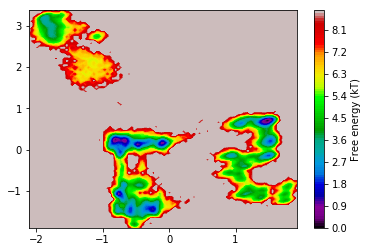

In [28]:
%matplotlib inline
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);


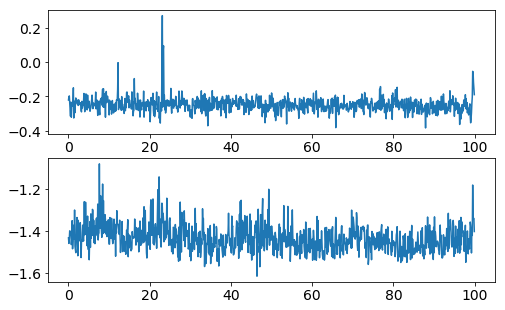

In [29]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
plt.figure(figsize=(8,5))
ax1=plt.subplot(211)
x = dt*np.arange(Y[0].shape[0])
plt.plot(x, Y[2][:,0]); ylabel=('IC 1'); xticks=([]); yticks=(np.arange(-8, 4, 2))
ax1=plt.subplot(212)
plt.plot(x, Y[2][:,1]); ylabel=('IC 2'); xticks=([]);  yticks=(np.arange(-6, 4, 2))


## Clustering

In [30]:
clustering = coor.cluster_mini_batch_kmeans(Y,k=n_clusters, max_iter=1000)


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


21-09-17 15:06:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2] INFO     Cluster centers converged after 98 steps.


In [31]:
dtrajs = clustering.dtrajs


Widget Javascript not detected.  It may not be installed or enabled properly.


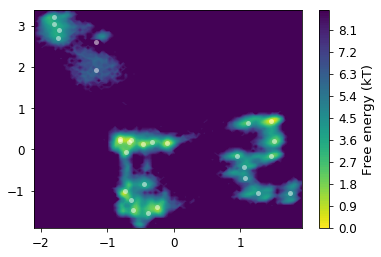

In [32]:
import seaborn as sns
with sns.plotting_context('paper', font_scale=1.5):
    mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')
    cc_x = clustering.clustercenters[:,0]
    cc_y = clustering.clustercenters[:,1]
    plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='white', alpha=0.5)

## Estimate MSM

In [33]:
msm_lag = 50
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  0.9310344827586207
fraction of counts used =  0.975


In [34]:
trial_data.loc[trial_index, 'state_fraction'] = M.active_state_fraction

In [35]:
from msmbuilder.msm import MarkovStateModel
mm = MarkovStateModel(lag_time=50)
mm.fit(dtrajs)

MSM contains 2 strongly connected components above weight=0.02. Component 0 selected, with population 97.500000%


MarkovStateModel(ergodic_cutoff='on', lag_time=50, n_timescales=None,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         use_gap=None, verbose=True)

## Bayesian MSM

In [36]:
from pyemma.msm import bayesian_markov_model


In [37]:
np.linspace(10,10000, 3)

array([    10.,   5005.,  10000.])

In [38]:
from msmbuilder.msm import BayesianMarkovStateModel


/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/

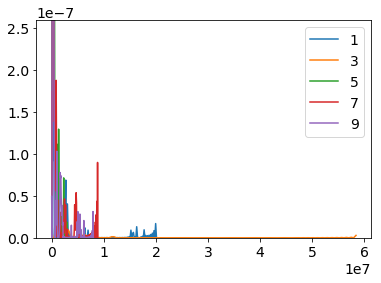

In [39]:

for i in range(1,11,2):
    bmm = BayesianMarkovStateModel(lag_time=50, n_samples=1000, n_chains=i)
    bmm.fit(dtrajs)
    timescales = bmm.all_timescales_
    sns.distplot(timescales.T[0], label='{}'.format(i), hist=False)

plt.legend()

/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])
/home/robert/anaconda3/envs/science/

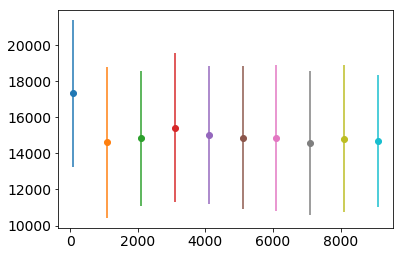

In [40]:
for i in range(1,101,10):
    bmm = BayesianMarkovStateModel(lag_time=50, n_samples=100*i, n_chains=5)
    bmm.fit(dtrajs)
    timescales = bmm.all_timescales_
    plt.errorbar(100*i, np.median(timescales.T[2]), yerr=np.std(timescales.T[2]),label='{}'.format(i), fmt='o')

# plt.legend()
# plt.ylim((0,0.00005))
# plt.yscale('log')

In [41]:
bmm = BayesianMarkovStateModel(lag_time=50, n_samples=2000, n_chains=5)
bmm.fit(dtrajs)
timescales = bmm.all_timescales_

/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/msmbuilder-3.9.0.dev0-py3.5-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:326: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])


In [42]:
ts_df = pd.DataFrame(timescales[:,:20])
ts_df = pd.melt(ts_df, var_name='Process', value_name='Timescale')
ts_df.head()

,Process,Timescale
0,0,440592.377017
1,0,193671.868978
2,0,185396.907222
3,0,191283.383789
4,0,191283.210422


In [43]:
ts_df['Process'] += 1
ts_df.head()

,Process,Timescale
0,1,440592.377017
1,1,193671.868978
2,1,185396.907222
3,1,191283.383789
4,1,191283.210422


In [44]:
ts_df['id']=trial_id

In [45]:
import os

if os.path.exists('bayesian_timescales.pickl'):
    all_ts_df = pd.read_pickle('bayesian_timescales.pickl')
    all_ts_df = pd.concat([all_ts_df, ts_df])
    all_ts_df.drop_duplicates(inplace=True)
    all_ts_df.to_pickle('bayesian_timescales.pickl')
else:
    ts_df.to_pickle('bayesian_timescales.pickl')

In [46]:
all_ts_df.tail()

,Process,Timescale,id
39995,20,107.120820,1540
39996,20,127.422185,1540
39997,20,114.026432,1540
39998,20,115.474175,1540
39999,20,119.780302,1540


In [47]:
# ratios = med_ts[:-1]/med_ts[1:]
# med_gap = np.max(ratios)
# sup_proc = np.argmax(ratios)+1


In [48]:
# slowest_fast = ts_df.loc[ts_df['Process']==sup_proc+1, 'Timescale'].values
# fastest_slow = ts_df.loc[ts_df['Process']==sup_proc, 'Timescale'].values

In [49]:
# n_samples = int(1e5)
# gaps = np.zeros(n_samples)
# for i in range(n_samples):
#     fast = np.random.choice(slowest_fast, size=1)
#     slow = np.random.choice(fastest_slow, size=1)
#     gaps[i] = slow/fast
    

In [50]:
# gaps_df = pd.DataFrame(data={'Gaps': gaps})


In [51]:
# trial_data.loc[trial_index, 'ts_gap'] = np.median(gaps)
# trial_data.loc[trial_index, 'ts_gap_5pc'] = np.percentile(gaps, 5)
# trial_data.loc[trial_index, 'ts_gap_95pc'] = np.percentile(gaps, 95)
# trial_data.loc[trial_index, 'n_csp']= sup_proc

## Timescales - MLE


In [52]:
ts = mm.timescales_
ratios = ts[:-1]/ts[1:]
gap = np.max(ratios)
sup_proc = np.argmax(ratios)+1

In [53]:
print('Gap is {:4.2f}'.format(gap))
print('Slow processes are {}'.format(np.arange(sup_proc)+1))
ts /= 1e3

Gap is 13.95
Slow processes are [1 2]


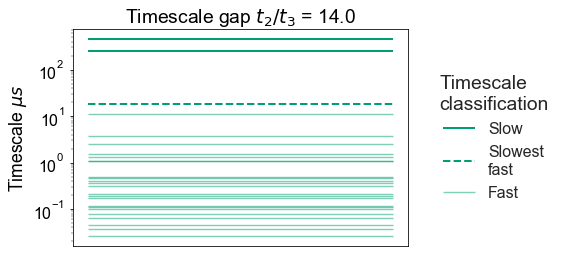

In [54]:
from matplotlib.ticker import *
ticker = FixedLocator([])
cols = sns.color_palette('colorblind')
cols = [cols[1], cols[0]]
with sns.plotting_context('paper', font_scale=2):
    # plot all timescales
    fig, ax = plt.subplots()
    sns.set_style('whitegrid')
    
    for t in ts[:sup_proc]:
        slow = ax.hlines(t, 0, 1, color=cols[0], label='Slow', alpha=1, linewidth=2)
    sfast = ax.hlines(ts[sup_proc],0,1, color=cols[0], label='Slowest\nfast', alpha=1, linewidth=2, 
             linestyle='dashed')
    for t in ts[sup_proc+1:]:
        fast = ax.hlines(t, 0, 1, color=cols[0], label='Fast', alpha=0.5)

    ax.set_yscale('log')
    ax.set_ylabel(r'Timescale $\mu s$')

    ax.set_title('Timescale gap $t_{%d}/t_{%d}$ = %4.1f' % (sup_proc, sup_proc+1, gap) )
    ax.legend(handles=[slow, sfast, fast], bbox_to_anchor=(1.05,0.5), loc='center left', 
             title='Timescale\nclassification')
    ax.xaxis.set_major_locator(ticker)

plt.savefig('msm_figures/'+froot+'-timescales.png', bbox_inches='tight')

## Coarse Grain

In [55]:
n_sets = sup_proc+1
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership = M.metastable_memberships  
active_set = M.active_set
# Need to take into account unassigned states! 
# get PCCA memberships
# memberships over trajectory
# dist_all = [np.hstack([pcca_dist[i,:][dtraj] if dtraj in active_set else np.nan for dtraj in M.discrete_trajectories_full]) 
#             for i in range(n_sets)]
# mem_all = [np.hstack([membership[:,i][dtraj] if dtraj in active_set else np.nan for dtraj in M.discrete_trajectories_full]) 
#            for i in range(n_sets)]

In [56]:
pcca_samples = M.sample_by_distributions(pcca_dist, 100)

In [57]:
output_files = ['metastable_states/'+froot+'-pcca{}.xtc'.format(i+1) for i in range(n_sets)]
output_files

['metastable_states/fixed-1540-pcca1.xtc',
 'metastable_states/fixed-1540-pcca2.xtc',
 'metastable_states/fixed-1540-pcca3.xtc']

In [58]:
coor.save_trajs(inp, pcca_samples, outfiles=output_files)

/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:97: RuntimeWarning: invalid value encountered in greater
  a[np.logical_and(a>-tol, a<tol)] = 0.0
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:97: RuntimeWarning: invalid value encountered in less
  a[np.logical_and(a>-tol, a<tol)] = 0.0
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:98: RuntimeWarning: invalid value encountered in greater
  b[np.logical_and(b>-tol, b<tol)] = 0.0
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:98: RuntimeWarning: invalid value encountered in less
  b[np.logical_and(b>-tol, b<tol)] = 0.0
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/mdtraj/utils/unitcell.py:99: RuntimeWarning: invalid value encountered in greater
  c[np.logical_and(c>-tol, c<tol)] = 0.0
/home/robert/anaconda3/envs/science/lib/python3.5/site-packages/mdtraj/

['metastable_states/fixed-1540-pcca1.xtc',
 'metastable_states/fixed-1540-pcca2.xtc',
 'metastable_states/fixed-1540-pcca3.xtc']

## Hidden Markov Model

In [59]:
hmm = msm.estimate_hidden_markov_model(dtrajs, nstates=n_sets, lag=50, connectivity='all')

In [60]:
hmm.stationary_distribution

array([ 0.0775,  0.2875,  0.635 ])

In [61]:
hmm.P

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

## Assignment of states

In [62]:
# ax = plt.subplot2grid((2, 2), (0, 0))
# ax = plt.subplot(2, 2, 1)


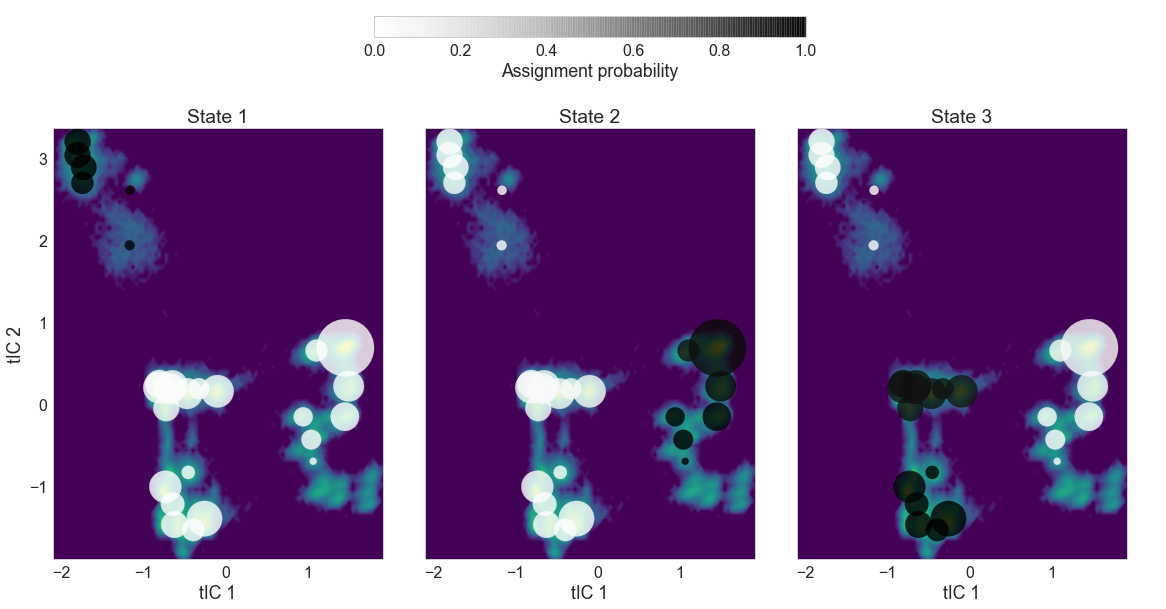

In [63]:
import seaborn as sns
from matplotlib.ticker import *
import matplotlib.gridspec as gridspec

with sns.plotting_context('paper', font_scale=2):
    
    fig = plt.figure(figsize=(20,10))

    nrows = 2
    ncols = n_sets

    gs = gridspec.GridSpec(nrows, ncols, height_ratios=[0.05,1])
    plot_axes = [plt.subplot(gs[1,i]) for i in range(ncols)]
    cb_axes = plt.subplot(gs[0,:])


    for i, ax in enumerate(plot_axes):
        use_cbar = i==0
        mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r', ax=ax, cbar=False)

        cc_x = clustering.clustercenters[active_set,0]
        cc_y = clustering.clustercenters[active_set,1]
        cax = ax.scatter(cc_x,cc_y, marker='o', 
                    s=50*M.pi/np.min(M.pi), 
                    c=membership.T[i], 
                    alpha=0.8, cmap='Greys')
        ax.set(aspect='equal')
        ax.set_title('State {}'.format(i+1))
        if i == 0:
            ax.set_ylabel('tIC 2')
        ax.set_xlabel('tIC 1')
    
    for i, ax in enumerate(plot_axes[1:]):
        plt.setp(ax.get_yticklabels(), visible=False)

    cb_axes.axis('off')
    cb = fig.colorbar(cax, ax=cb_axes, label='Assignment probability', orientation='horizontal', fraction=1, shrink=0.4)
    fig.subplots_adjust(wspace=0.00, hspace=0.4)
    
    plt.savefig('msm_figures/'+froot+'-metastable_states.png')


## Eigenvectors

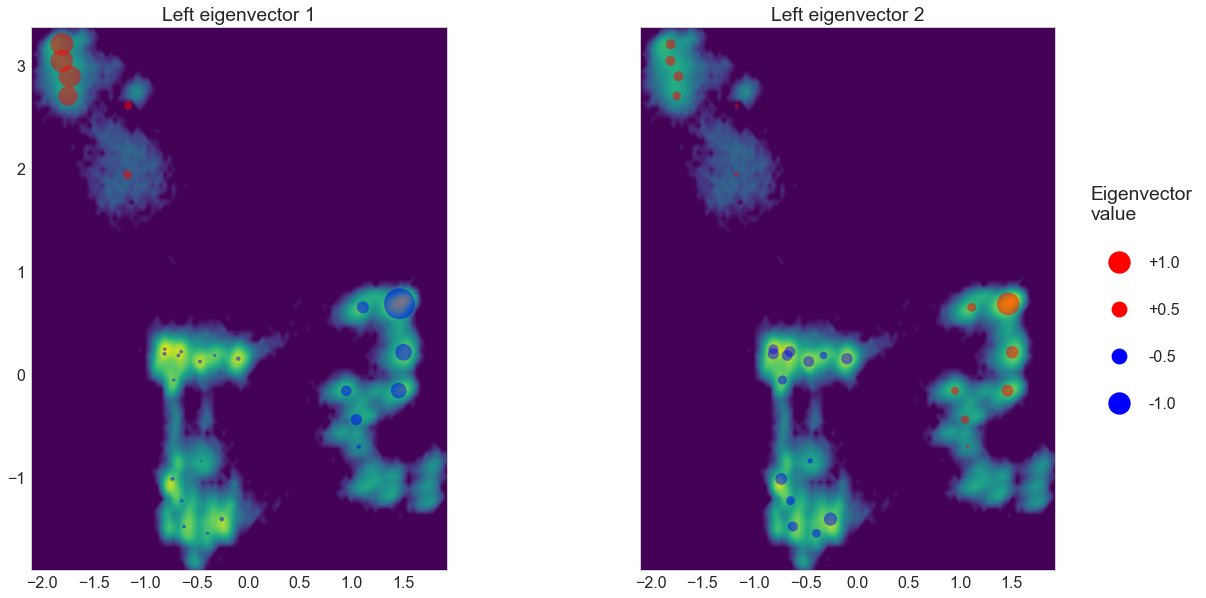

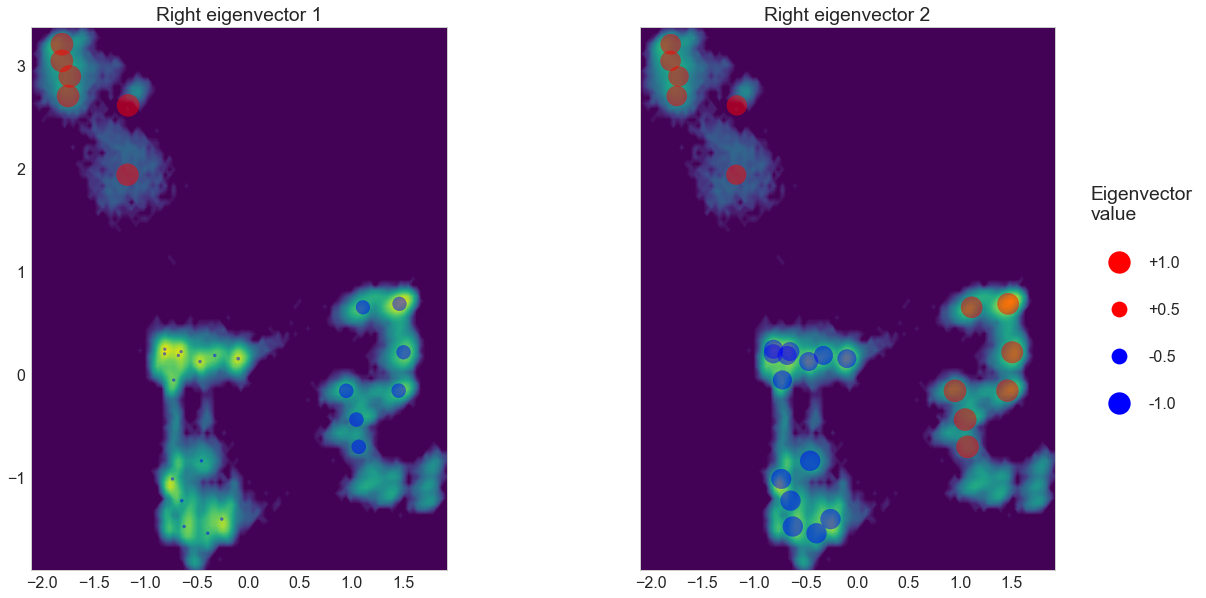

In [64]:
import seaborn as sns
import matplotlib.lines as mlines

with sns.plotting_context('paper', font_scale=2):
    
    for vec in ['Left', 'Right']:
    
#         fig, axes = plt.subplots(1,n_sets-1,  sharex=True, sharey=True, figsize=(5,12))
        

        nrows = 1
        ncols = n_sets-1
        fig, plot_axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20,10))

#         gs = gridspec.GridSpec(nrows, ncols, height_ratios=[1,0.05], hspace=0.4)
#         plot_axes = [plt.subplot(gs[0,i]) for i in range(ncols)]
#         cb_axes = plt.subplot(gs[1,:])
    
        if ncols> 1:
            axes = plot_axes.flatten()
        else:
            axes = [plot_axes]
        for i, ax in enumerate(axes):
            mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r', ax=ax, cbar=False)

            cc_x = clustering.clustercenters[active_set,0]
            cc_y = clustering.clustercenters[active_set,1]
            
            if vec=='Left':
                eigvecs = M.eigenvectors_left()[i+1]
                
            elif vec=='Right':
                eigvecs = M.eigenvectors_right().T[i+1]
            pref = 5e2
            sscale = pref*np.abs(eigvecs)/np.max(eigvecs)
            cax = ax.scatter(cc_x,cc_y, marker='o', 
                        s=sscale, 
                        c=eigvecs/np.abs(eigvecs), 
                        alpha=0.5, 
                        cmap="bwr")
            ax.set(adjustable='box-forced', aspect='equal')
            if i == n_sets-1:
                ax.set_xlabel('tIC 1')
                ax.set_ylabel('tIC 2')
            ax.set_title('{0} eigenvector {1}'.format(vec, i+1))
        # legend
        ms = np.sqrt(np.max(sscale))
        ms_s = np.sqrt(np.max(sscale)/2)

        pos_lab = '{:4.0f}'.format(np.max(sscale)/pref)
        pos = mlines.Line2D([],[],color='r', linestyle='', marker='o', label='+1.0', markersize=ms)
        pos_s = mlines.Line2D([],[],color='r', linestyle='', marker='o', label='+0.5', markersize=ms_s)

        neg = mlines.Line2D([],[],color='b', linestyle='', marker='o', label='-1.0', markersize=ms)
        neg_s = mlines.Line2D([],[],color='b', linestyle='', marker='o', label='-0.5', markersize=ms_s)

        axes[-1].legend(handles=[pos, pos_s, neg_s, neg], bbox_to_anchor=(1.05,0.5), title='Eigenvector\nvalue', 
                            labelspacing=2, loc='center left')
#         cb_axes.axis('off')
#         cbar = fig.colorbar(cax, ax=cb_axes, orientation='horizontal',fraction=1, shrink=0.4)
#         cbar.set_label(label='{} eigenvector value'.format(vec))
#         locator = LinearLocator(numticks=3)
#         cbar.ax.xaxis.set_major_locator(locator)
        plt.savefig('msm_figures/'+froot+'-{}-eigenvectors.png'.format(vec))



In [65]:
trial_data.to_pickle('best_trials_with_gaps.pickl')

## Baysian HMM

In [66]:
bhmm = msm.bayesian_hidden_markov_model(dtrajs, lag=50, nstates=2, nsamples=1000)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [67]:
pi = bhmm.stationary_distribution
piL,piR = bhmm.sample_conf('stationary_distribution')
for i in range(3): print(pi[i],' -',piL[i],'+',piR[i])

1.0  - 0.121419279562 + 0.999999999986
0.0  - 1.46228047558e-11 + 0.881552190728


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
bhmm.P

In [ ]:
hmm = msm.estimate_hidden_markov_model(dtrajs, lag=50, nstates=2)

In [ ]:
hmm.P